In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150
import numpy as np
import random

In [3]:
# 1. Connect to the Neo4j Database
uri = "bolt://localhost:7687"  # Adjust with your Neo4j URI
username = "neo4j"              # Replace with your username
password = "xinyu123"           # Replace with your password

from neo4j import GraphDatabase

driver = GraphDatabase.driver(uri, auth=(username, password), database='combine2')


In [32]:
def fetch_data(tx):
    # Query for nodes
    nodes_query_disease = """
    MATCH (n:DiseaseProfile)
    RETURN DISTINCT labels(n) AS node_type, id(n) AS node_id, n AS properties, n.id AS name
    """
    nodes_query_drug = """
    MATCH (n:DrugProfile)
    RETURN DISTINCT labels(n) AS node_type, id(n) AS node_id, n AS properties, n.drugbank_id AS name
    """
    nodes = list(tx.run(nodes_query_drug))+list(tx.run(nodes_query_disease))

    # Query for edges
    edges_query = """
    MATCH (n)-[r]->(m)
    RETURN DISTINCT type(r) AS rel_type, id(n) AS src, id(m) AS dst, r AS properties
    """
    edges = list(tx.run(edges_query))

    return nodes, edges

with driver.session() as session:
    nodes, edges = session.execute_read(fetch_data)


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated function: `id`.} {position: line: 3, column: 45, offset: 71} for query: '\n    MATCH (n:DrugProfile)\n    RETURN DISTINCT labels(n) AS node_type, id(n) AS node_id, n AS properties, n.drugbank_id AS name\n    '
Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated function: `id`.} {position: line: 3, column: 45, offset: 74} for query: '\n    MATCH (n:DiseaseProfile)\n    RETURN DISTINCT labels(n) AS node_type, id(n) AS node_id, n AS properties, n.id AS name\n    '
Received notification from DBMS server: {severit

In [40]:
from torch_geometric.data import HeteroData
import torch

# Initialize HeteroData
data = HeteroData()

# Step 3.1: Process Nodes
node_type_map = {}  # Map Neo4j IDs to PyG node indices
node_name_map = {}   
type_counter = {}    # Track the number of nodes per type

for node in nodes:
    node_type = node['node_type'][0]  # Assuming single label per node
    node_id = node['node_id']
    properties = node['properties']
    name = node['name']
    if node_type not in data.node_types:
        data[node_type].x = []  # Create an empty feature list for this type

    # Convert properties to tensor (dummy example: convert all to float)
    feature_vector =  torch.randn(4).float() #torch.tensor(list(properties.values()), dtype=torch.float)
    data[node_type].x.append(feature_vector)

    # Map Neo4j ID to PyG index
    if node_type not in node_type_map:
        node_type_map[node_type] = {}
    node_type_map[node_type][node_id] = type_counter.get(node_type, 0)
    node_name_map[name] = type_counter.get(node_type, 0)
    type_counter[node_type] = type_counter.get(node_type, 0) + 1

# Convert features to tensors
for node_type in data.node_types:
    data[node_type].x = torch.stack(data[node_type].x)

data['DiseaseProfile', 'TREATED_BY', 'DrugProfile'].edge_index = [[], []]
data['DiseaseProfile', 'CONTRAIND_BY', 'DrugProfile'].edge_index = [[], []]
data['DiseaseProfile', 'HAS_CHILDCODE', 'DiseaseProfile'].edge_index = [[], []]
data['DrugProfile', 'HAS_CHILDCODE', 'DrugProfile'].edge_index = [[], []]

In [41]:
data['DrugProfile'].x.shape, data['DiseaseProfile'].x.shape, len(node_name_map)

(torch.Size([20347, 4]), torch.Size([151045, 4]), 171392)

In [42]:
data

HeteroData(
  DrugProfile={ x=[20347, 4] },
  DiseaseProfile={ x=[151045, 4] },
  (DiseaseProfile, TREATED_BY, DrugProfile)={ edge_index=[2] },
  (DiseaseProfile, CONTRAIND_BY, DrugProfile)={ edge_index=[2] },
  (DiseaseProfile, HAS_CHILDCODE, DiseaseProfile)={ edge_index=[2] },
  (DrugProfile, HAS_CHILDCODE, DrugProfile)={ edge_index=[2] }
)

In [43]:

# Step 3.2: Process Edges
for edge in edges:
    rel_type = edge['rel_type']
    src_id = edge['src']
    dst_id = edge['dst']
    properties = edge['properties']

    # Find node types of src and dst
    src_type = [key for key, val in node_type_map.items() if src_id in val][0]
    dst_type = [key for key, val in node_type_map.items() if dst_id in val][0]

    # Get PyG indices
    src_idx = node_type_map[src_type][src_id]
    dst_idx = node_type_map[dst_type][dst_id]

    # Add edge to HeteroData
    edge_type = (src_type, rel_type, dst_type)
    if edge_type not in data.edge_types:
        data[edge_type].edge_index = [[], []]  # Initialize edge index
    data[edge_type].edge_index[0].append(src_idx)
    data[edge_type].edge_index[1].append(dst_idx)

    if rel_type == 'INTERACTS':
        data[edge_type].edge_index[0].append(dst_idx)
        data[edge_type].edge_index[1].append(src_idx)
    elif rel_type == 'TREATS':
        data[(dst_type,'TREATED_BY',src_type)].edge_index[0].append(dst_idx)
        data[(dst_type,'TREATED_BY',src_type)].edge_index[1].append(src_idx)
    elif rel_type == 'HAS_CONTRAIND':
        data[(dst_type,'CONTRAIND_BY',src_type)].edge_index[0].append(dst_idx)
        data[(dst_type,'CONTRAIND_BY',src_type)].edge_index[1].append(src_idx)
    elif rel_type == 'HAS_PARENTCODE':
        data[(dst_type,'HAS_CHILDCODE',src_type)].edge_index[0].append(dst_idx)
        data[(dst_type,'HAS_CHILDCODE',src_type)].edge_index[1].append(src_idx)

# Convert edge indices to tensors
for edge_type in data.edge_types:
    edge_index = data[edge_type].edge_index
    data[edge_type].edge_index = torch.tensor(edge_index, dtype=torch.long)


In [44]:
with open('data/node_name_map.pkl', 'wb') as f:
    import pickle
    pickle.dump(node_name_map, f)


In [66]:
len(node_name_map), len(data['DiseaseProfile'].x)+ len(data['DrugProfile'].x), len(data['DrugProfile'].x)

(171392, 171392, 20347)

In [46]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import HeteroConv, GCNConv, SAGEConv, GATConv, RGCNConv
import pandas as pd

In [47]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    # torch.backends.cudnn.deterministic = True
    # torch.backends.cudnn.benchmark = False

In [48]:
def similarity_loss(embeddings, similar_pairs, dissimilar_pairs, margin=1.0):
    """
    Compute similarity loss: aiming for smaller loss for similiar drugs and bigger loss for dissimilar drugs

    params:
    - embeddings: for drug
    - similar_pairs: [(i, j), ...] list of similar pair
    - dissimilar_pairs: [(i, j), ...] list of disimilar pair
    - margin: minimum distance between disimilar drug pair

    return:
    - loss: L2
    """
    loss = 0
    # similar drug should be close
    for i, j in similar_pairs:
        loss += torch.norm(embeddings[i] - embeddings[j], p=2)

    # dissimilar drug should be far away
    for i, j in dissimilar_pairs:
        loss += F.relu(margin - torch.norm(embeddings[i] - embeddings[j], p=2))
    
    return loss / (len(similar_pairs) + len(dissimilar_pairs))


In [49]:
data

HeteroData(
  DrugProfile={ x=[20347, 4] },
  DiseaseProfile={ x=[151045, 4] },
  (DiseaseProfile, TREATED_BY, DrugProfile)={ edge_index=[2, 33279] },
  (DiseaseProfile, CONTRAIND_BY, DrugProfile)={ edge_index=[2, 14627] },
  (DiseaseProfile, HAS_CHILDCODE, DiseaseProfile)={ edge_index=[2, 94314] },
  (DrugProfile, HAS_CHILDCODE, DrugProfile)={ edge_index=[2, 10112] },
  (DrugProfile, INTERACTS, DrugProfile)={ edge_index=[2, 229006] },
  (DrugProfile, TREATS, DiseaseProfile)={ edge_index=[2, 33279] },
  (DrugProfile, HAS_CONTRAIND, DiseaseProfile)={ edge_index=[2, 14627] },
  (DrugProfile, HAS_PARENTCODE, DrugProfile)={ edge_index=[2, 10112] },
  (DiseaseProfile, HAS_PARENTCODE, DiseaseProfile)={ edge_index=[2, 94314] }
)

In [50]:
class DrugDiseaseHeteroGAT(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        
        # Use HeteroConv to assign different conv layer to different relationships
        self.convs = HeteroConv({
            ('DrugProfile', 'TREATS', 'DiseaseProfile'): GATConv((-1,-1), hidden_channels, add_self_loops=False),
            ('DiseaseProfile', 'TREATED_BY', 'DrugProfile'): GATConv((-1,-1), hidden_channels, add_self_loops=False),
            ('DrugProfile', 'HAS_CONTRAIND', 'DiseaseProfile'): GATConv((-1,-1), hidden_channels, add_self_loops=False),
            ('DiseaseProfile', 'CONTRAIND_BY', 'DrugProfile'): GATConv((-1,-1), hidden_channels, add_self_loops=False),
            ('DiseaseProfile', 'HAS_PARENTCODE', 'DiseaseProfile'): GATConv((-1,-1), hidden_channels, add_self_loops=False),
            ('DiseaseProfile', 'HAS_CHILDCODE', 'DiseaseProfile'): GATConv((-1,-1), hidden_channels, add_self_loops=False),
            ('DrugProfile', 'INTERACTS', 'DrugProfile'): GATConv(-1, hidden_channels, add_self_loops=False)
        }, aggr='sum')  # aggregator can also be 'mean' or 'max'

        self.convs2 = HeteroConv({
            ('DrugProfile', 'TREATS', 'DiseaseProfile'): GATConv((-1,-1), hidden_channels, add_self_loops=False),
            ('DiseaseProfile', 'TREATED_BY', 'DrugProfile'): GATConv((-1,-1), hidden_channels, add_self_loops=False),
            ('DrugProfile', 'HAS_CONTRAIND', 'DiseaseProfile'): GATConv((-1,-1), hidden_channels, add_self_loops=False),
            ('DiseaseProfile', 'CONTRAIND_BY', 'DrugProfile'): GATConv((-1,-1), hidden_channels, add_self_loops=False),
            ('DiseaseProfile', 'HAS_PARENTCODE', 'DiseaseProfile'): GATConv((-1,-1), hidden_channels, add_self_loops=False),
            ('DiseaseProfile', 'HAS_CHILDCODE', 'DiseaseProfile'): GATConv((-1,-1), hidden_channels, add_self_loops=False),
            ('DrugProfile', 'INTERACTS', 'DrugProfile'): GATConv(-1, hidden_channels, add_self_loops=False)
        }, aggr='sum')  # aggregator can also be 'mean' or 'max'

        # output layer
        self.lin_drug = torch.nn.Linear(hidden_channels, out_channels)
        self.lin_disease = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, x_dict, edge_index_dict):
        # use HeteroConv to feed forward
        x_dict = self.convs(x_dict, edge_index_dict)
        x_dict = {key: F.relu(x) for key, x in x_dict.items()}
        x_dict = self.convs2(x_dict, edge_index_dict)
        # linear + ReLU activation 
        x_dict['DrugProfile'] = F.relu(self.lin_drug(x_dict['DrugProfile']))
        x_dict['DiseaseProfile'] = F.relu(self.lin_disease(x_dict['DiseaseProfile']))
        
        return x_dict


In [51]:
class DrugDiseaseHeteroSAGE(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        
        # Use HeteroConv to assign different conv layer to different relationships
        self.convs = HeteroConv({
            ('DrugProfile', 'TREATS', 'DiseaseProfile'): SAGEConv((-1,-1), hidden_channels),
            ('DiseaseProfile', 'TREATED_BY', 'DrugProfile'): SAGEConv((-1,-1), hidden_channels),
            ('DrugProfile', 'HAS_CONTRAIND', 'DiseaseProfile'): SAGEConv((-1,-1), hidden_channels),
            ('DiseaseProfile', 'CONTRAIND_BY', 'DrugProfile'): SAGEConv((-1,-1), hidden_channels),
            ('DiseaseProfile', 'HAS_PARENTCODE', 'DiseaseProfile'): SAGEConv((-1,-1), hidden_channels),
            ('DiseaseProfile', 'HAS_CHILDCODE', 'DiseaseProfile'): SAGEConv((-1,-1), hidden_channels),
            ('DrugProfile', 'INTERACTS', 'DrugProfile'): SAGEConv(-1, hidden_channels)
        }, aggr='sum')  # aggregator can also be 'mean' or 'max'

        self.convs2 = HeteroConv({
            ('DrugProfile', 'TREATS', 'DiseaseProfile'): SAGEConv((-1,-1), hidden_channels),
            ('DiseaseProfile', 'TREATED_BY', 'DrugProfile'): SAGEConv((-1,-1), hidden_channels),
            ('DrugProfile', 'HAS_CONTRAIND', 'DiseaseProfile'): SAGEConv((-1,-1), hidden_channels),
            ('DiseaseProfile', 'CONTRAIND_BY', 'DrugProfile'): SAGEConv((-1,-1), hidden_channels),
            ('DiseaseProfile', 'HAS_PARENTCODE', 'DiseaseProfile'): SAGEConv((-1,-1), hidden_channels),
            ('DiseaseProfile', 'HAS_CHILDCODE', 'DiseaseProfile'): SAGEConv((-1,-1), hidden_channels),
            ('DrugProfile', 'INTERACTS', 'DrugProfile'): SAGEConv(-1, hidden_channels)
        }, aggr='sum')  # aggregator can also be 'mean' or 'max'

        # output layer
        self.lin_drug = torch.nn.Linear(hidden_channels, out_channels)
        self.lin_disease = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, x_dict, edge_index_dict):
        # use HeteroConv to feed forward
        x_dict = self.convs(x_dict, edge_index_dict)
        x_dict = {key: F.relu(x) for key, x in x_dict.items()}
        x_dict = self.convs2(x_dict, edge_index_dict)
        # linear + ReLU activation 
        x_dict['DrugProfile'] = F.relu(self.lin_drug(x_dict['DrugProfile']))
        x_dict['DiseaseProfile'] = F.relu(self.lin_disease(x_dict['DiseaseProfile']))
        
        return x_dict


In [ ]:
# Initialization
model = DrugDiseaseHeteroGAT(hidden_channels=64, out_channels=32)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Define similar and dissimilar pairs
similar_pairs = [(node_name_map['DB00999'], node_name_map['DB00598']),  # similar treatment Hydrochlorothiazide Labetalol
                 (node_name_map['DB00945'], node_name_map['DB00758'])]  # similar treatment  Acetylsalicylic acid   Clopidogrel
dissimilar_pairs = [(node_name_map['DB00999'], node_name_map['DB00945']),  # interaction Hydrochlorothiazide  Acetylsalicylic acid
                    (node_name_map['DB01001'], node_name_map['DB00758'])]  # conindication Salbutamol   Clopidogrel

# set_seed(42)
for epoch in range(90):
    model.train()
    optimizer.zero_grad()

    out = model(data.x_dict, data.edge_index_dict)
    drug_embeddings = out['DrugProfile']

    loss = similarity_loss(drug_embeddings, similar_pairs, dissimilar_pairs)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')


Epoch 0, Loss: 0.5123076438903809
Epoch 10, Loss: 0.1264623999595642
Epoch 20, Loss: 0.08572164177894592
Epoch 30, Loss: 0.020261235535144806
Epoch 40, Loss: 0.009672974236309528
Epoch 50, Loss: 0.004416831769049168
Epoch 60, Loss: 0.003976739943027496
Epoch 70, Loss: 0.0034017041325569153
Epoch 80, Loss: 0.0028383980970829725


In [56]:
for name, param in model.named_parameters():
    print(f"Parameter name: {name}")
    print(f"Parameter value: {param}")


Parameter name: convs.convs.<DrugProfile___TREATS___DiseaseProfile>.att_src
Parameter value: Parameter containing:
tensor([[[ 0.0785,  0.2832, -0.2843,  0.2106,  0.2206,  0.1054,  0.1143,
          -0.1729,  0.0887, -0.1567,  0.1782,  0.0735, -0.2079, -0.0540,
          -0.2035,  0.0769,  0.1231, -0.1412, -0.2175,  0.0954,  0.2553,
           0.0869, -0.2273, -0.1081, -0.2171, -0.1531,  0.1754, -0.1206,
          -0.1154, -0.0014, -0.0359, -0.2387,  0.1578,  0.2852, -0.2574,
           0.1043,  0.1124,  0.0099,  0.1765,  0.2478,  0.2424,  0.1070,
          -0.2086,  0.0664, -0.0613, -0.0419,  0.1531, -0.2176, -0.0504,
          -0.0061,  0.2937,  0.1337,  0.0750,  0.1439, -0.0705,  0.1770,
          -0.0704, -0.0448, -0.2198, -0.0610,  0.0978,  0.2651, -0.2345,
          -0.1227]]], requires_grad=True)
Parameter name: convs.convs.<DrugProfile___TREATS___DiseaseProfile>.att_dst
Parameter value: Parameter containing:
tensor([[[-0.0791, -0.1404,  0.1033, -0.3435,  0.0030, -0.1611, -0.2183

In [57]:
drugs = [
    # for hypertension
    # "Hydrochlorothiazide", "Labetalol",
    "DB00999", "DB00598",
    # for diabetes
    # "Metformin", "Glyburide", "Insulin human",
    "DB00331", "DB01016", "DB00030",
    # for coronary artery disease
    # "Acetylsalicylic acid", "Clopidogrel", "Pravastatin",
    "DB00945", "DB00758", "DB00175",
    # for asthma
    # "Salbutamol", "Budesonide"
    "DB01001", "DB01222",
    ]

In [58]:
sub_drug_embeddings = drug_embeddings[[node_name_map[drug] for drug in drugs]]
sub_drug_embeddings.shape

torch.Size([10, 32])

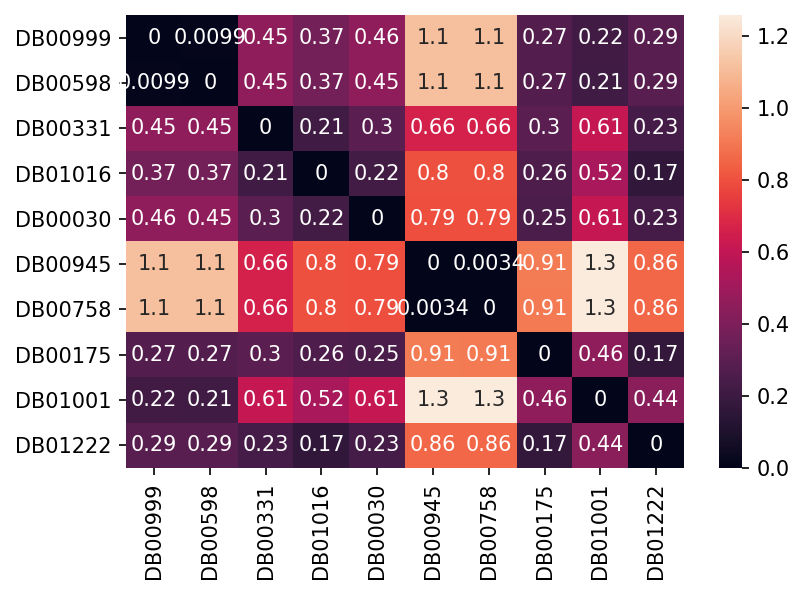

In [60]:
diff = sub_drug_embeddings.unsqueeze(1) - sub_drug_embeddings.unsqueeze(0)  # Shape: [12, 12, 16]
dist_squared = torch.sum(diff ** 2, dim=-1)  # Shape: [12, 12]

# Compute L2 distance matrix
l2_distances = torch.sqrt(dist_squared)

df_dist = pd.DataFrame(l2_distances.detach().numpy(), columns = drugs, index = drugs)
sns.heatmap(df_dist, annot=True)
plt.show()

In [61]:
torch.save(drug_embeddings, 'drug_emed_new.pt')